### Import modules and constants

In [1]:
import json
import os
import argparse
from collections import Counter
import csv

baseline_packets = {"registered": {"Monday": 11709971, "Tuesday": 11551954, "Wednesday": 13788878, "Thursday": 9322025, "Friday": 9997874}}

packets_to_clone=200
countmin_time_threshold=10
countmin_width=16384

### Define the functions that can read the alerts and number of packets redirected from the results

In [22]:
def read_snort_alerts(alert_filepath):
	no_duplicates_data = {}
	data = []
	with open(alert_filepath) as file:
		try:
			for line in file.readlines():
				parsed_line = json.loads(line)
				data.append(parsed_line)

				entry_key = str(parsed_line["pkt_num"]) + parsed_line["rule"] + parsed_line["timestamp"]
				if entry_key not in no_duplicates_data:
					no_duplicates_data[entry_key] = line	
		except Exception as e:
			print("JSON error: ", e)
	return data,  no_duplicates_data

def read_amt_of_cloned_pkts(p4_output_filepath):
	try:
		with open(p4_output_filepath) as file:
			packets_cloned = 0
			get_data = False
			previous_line = ""
			for line in file:
				if "Counter name:  MyEgress.cloned_to_ids" in previous_line and "Index (port):  index: 2" in line:
					get_data = True
				
				if "packet_count" in line and get_data==1:
					packets_cloned += int(line.split()[1])
					get_data = False

				previous_line = line
	except:
		print("No output file in this folder")
	return packets_cloned

### Read baseline alerts

In [3]:
baseline_alerts_folder="../../baseline_alerts/CICIDS2017/alerts_snort3-registered"

def read_baseline(baseline_folder):
	baseline_data = {}
	for alert_file in os.listdir(baseline_folder):
		item_fullpath = os.path.join(baseline_folder, alert_file)

		raw_data, rules_counter, no_duplicates_data =  read_snort_alerts(item_fullpath)
		baseline_data[alert_file.split(".")[0]]={"alerts": no_duplicates_data, "counter": rules_counter}
	
	return baseline_data

baseline_data = read_baseline(baseline_alerts_folder)

### Read the results of one complete experiment: Monday, Tuesday, etc.

In [23]:
def read_experiments_data(experiments_data_folder):
	folder_data = {}
	for item in os.listdir(experiments_data_folder):
		item_fullpath = os.path.join(experiments_data_folder, item)
		if os.path.isfile(item_fullpath):
			continue

		no_duplicates_data, final_data = {}, {}		
		for subdir in sorted(os.listdir(item_fullpath)):
			if os.path.isfile(os.path.join(item_fullpath, subdir)):
				continue

			alert_file = os.path.join(item_fullpath, subdir) + "/alert_json.txt"
			data, no_duplicates =  read_snort_alerts(alert_file)
			this_subdir_rules = set()
			for key, value in no_duplicates.items():
				packet = json.loads(value)
				new_key = packet["proto"]+str(packet["pkt_len"])+packet["dir"]+packet["src_ap"]+packet["dst_ap"]+packet["rule"]
				if new_key not in no_duplicates_data:
					no_duplicates_data[new_key] = value
					final_data[value] = value
					this_subdir_rules.add(new_key)
					
				if new_key in no_duplicates_data and new_key in this_subdir_rules:
					final_data[value] = value

		packets_cloned = read_amt_of_cloned_pkts(os.path.join(item_fullpath, "output.txt"))
		folder_data[item]={"alerts": final_data, "packets_cloned": packets_cloned}
	return folder_data

### Parse the parameters evaluation experiments

In [24]:
input_folder = "../../../final_evaluation_results"
output_folder = "./"
csv_data = []
for item in os.listdir(input_folder):
    item_fullpath = os.path.join(input_folder, item)
    if os.path.isfile(item_fullpath):
        continue

    folder_name_elements = item.split("_") # linear_simple_100_registered
    experiments_data = read_experiments_data(item_fullpath)
     
    for key, data in experiments_data.items():
        csv_line = {}
        
        csv_line["PCAP"] = key
        csv_line["Topology"] = folder_name_elements[0]
        if (len(folder_name_elements)>4):
            csv_line["Offloading algorithm"] = folder_name_elements[1]+folder_name_elements[4]
        else:
            csv_line["Offloading algorithm"] = folder_name_elements[1]
        csv_line["Available space (%)"] = folder_name_elements[2]
        csv_line["Alerts"] = len(data["alerts"])
        csv_line["% of alerts relative to the baseline"] =  len(data["alerts"])/len(baseline_data[key]["alerts"])
        csv_line["Packets cloned to NIDS"] = data["packets_cloned"]
        csv_line["% of packets cloned to NIDS relative to the baseline"] =  \
                 data["packets_cloned"]/baseline_packets[folder_name_elements[3]][key]
        csv_data.append(csv_line)


keys = csv_data[0].keys()
output_file = output_folder + "/final_evaluation.csv"
with open(output_file, 'w') as file:
    w = csv.DictWriter(file, keys)
    w.writeheader()

    for line in csv_data:
        w.writerow(line)

### Importing data mining and plotting libraries

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


final_eval_df = pd.read_csv(output_file, sep=",")
final_eval_df

,PCAP,Topology,Offloading algorithm,Available space (%),Alerts,% of alerts relative to the baseline,Packets cloned to NIDS,% of packets cloned to NIDS relative to the baseline
0,Wednesday,linear,firstfit,25,57722,0.139058,4297278,0.311648
1,Monday,linear,firstfit,25,59899,0.908896,2892314,0.246996
2,Thursday,linear,firstfit,25,55058,0.741272,2562757,0.274914
3,Tuesday,linear,firstfit,25,52551,0.626054,2811476,0.243377
4,Friday,linear,firstfit,25,62756,0.928755,3416382,0.341711
...,...,...,...,...,...,...,...,...
135,Wednesday,tree,firstfit,75,57717,0.139046,3942966,0.285953
136,Monday,tree,firstfit,75,59801,0.907409,2502765,0.213729
137,Thursday,tree,firstfit,75,55384,0.745661,2244464,0.240770
138,Tuesday,tree,firstfit,75,52161,0.621408,2461421,0.213074


In [27]:
simple_df = final_eval_df[(final_eval_df["Offloading algorithm"] == "simple")]
simple_random = final_eval_df[(final_eval_df["Offloading algorithm"] == "simplerandom")]

linear_firstfit = final_eval_df[(final_eval_df["Topology"]=="linear") & (final_eval_df["Offloading algorithm"]=="firstfit")]
linear_bestfit = final_eval_df[(final_eval_df["Topology"]=="linear") & (final_eval_df["Offloading algorithm"]=="bestfit")]
tree_firstfit = final_eval_df[(final_eval_df["Topology"]=="tree") & (final_eval_df["Offloading algorithm"]=="firstfit")]
tree_bestfit = final_eval_df[(final_eval_df["Topology"]=="tree") & (final_eval_df["Offloading algorithm"]=="bestfit")]

simple_df

,PCAP,Topology,Offloading algorithm,Available space (%),Alerts,% of alerts relative to the baseline,Packets cloned to NIDS,% of packets cloned to NIDS relative to the baseline
50,Wednesday,linear,simple,50,57581,0.138718,3823853,0.277314
51,Monday,linear,simple,50,60215,0.913691,2382962,0.203499
52,Thursday,linear,simple,50,55274,0.744180,2164234,0.232164
53,Tuesday,linear,simple,50,52727,0.628151,2375455,0.205632
54,Friday,linear,simple,50,62823,0.929747,2937751,0.293838
65,Wednesday,linear,simple,100,57419,0.138328,3942710,0.285934
66,Monday,linear,simple,100,60280,0.914678,2502690,0.213723
67,Thursday,linear,simple,100,54864,0.738660,2244248,0.240747
68,Tuesday,linear,simple,100,52662,0.627377,2461318,0.213065
69,Friday,linear,simple,100,62585,0.926225,3085602,0.308626


In [28]:
alerts_plot_ylabel = "% of alerts relative to the baseline"
packets_cloned_plot_ylabel = "% of packets cloned to the NIDS\n relative to the baseline"

### Plot dataframe results for "simple" algorithm and linear topology

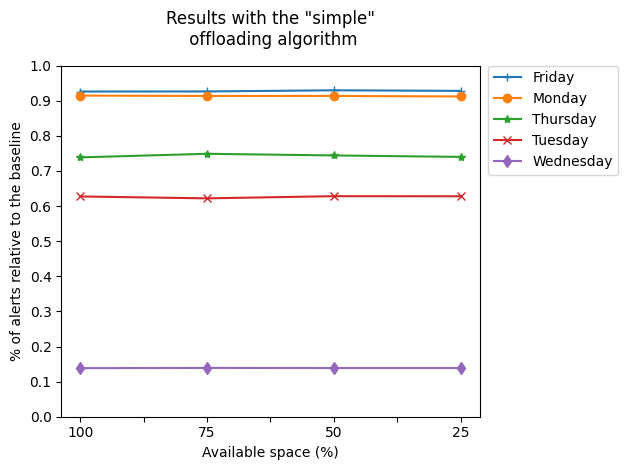

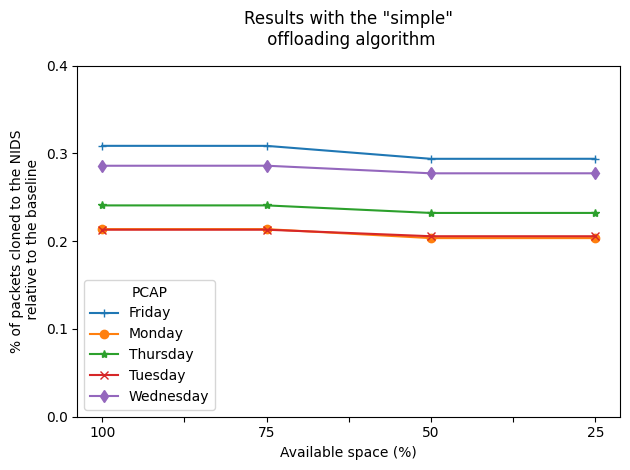

In [49]:
alerts_simple_df = simple_df[["PCAP", "Available space (%)", "% of alerts relative to the baseline"]].pivot_table("% of alerts relative to the baseline", ["Available space (%)"], "PCAP")
packets_simple_df = simple_df[["PCAP", "Available space (%)", "% of packets cloned to NIDS relative to the baseline"]].pivot_table("% of packets cloned to NIDS relative to the baseline", ["Available space (%)"], "PCAP")

alerts_simple_df.index = alerts_simple_df.index.map(str)
packets_simple_df.index = packets_simple_df.index.map(str)

alerts_simple_df = alerts_simple_df[::-1]
packets_simple_df = packets_simple_df[::-1]


alerts_simple_df.plot(style=['+-', 'o-', '*-', 'x-', 'd-'])
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left', borderaxespad=0)
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.ylim(0,1)
plt.ylabel(alerts_plot_ylabel)
plt.title('Results with the "simple"\n offloading algorithm', pad=15)
plt.tight_layout()
plt.savefig('graphs/Alerts_simple.png')
plt.show()

packets_simple_df.plot(style=['+-', 'o-', '*-', 'x-', 'd-'])
plt.yticks(np.arange(0, 0.5, step=0.1))
plt.ylim(0,0.4)
plt.ylabel(packets_cloned_plot_ylabel)
plt.title('Results with the "simple"\n offloading algorithm', pad=15)
plt.tight_layout()
plt.savefig('graphs/Packets_cloned_simple.png')
plt.show()

### Plot dataframe results for the "simple random" algorithm

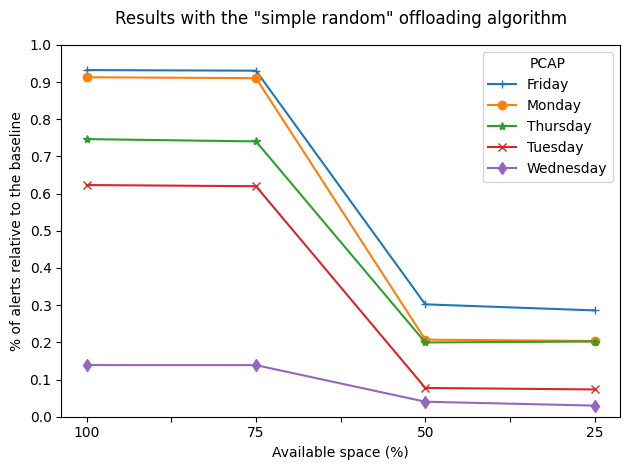

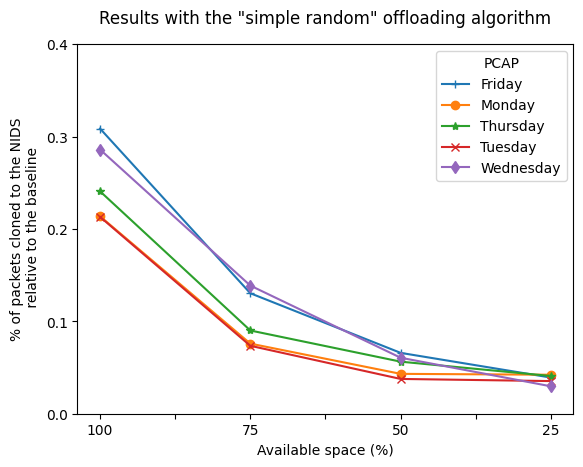

In [45]:
alerts_simple_random_df = simple_random[["PCAP", "Available space (%)", "% of alerts relative to the baseline"]].pivot_table("% of alerts relative to the baseline", ["Available space (%)"], "PCAP")
packets_simple_random_df = simple_random[["PCAP", "Available space (%)", "% of packets cloned to NIDS relative to the baseline"]].pivot_table("% of packets cloned to NIDS relative to the baseline", ["Available space (%)"], "PCAP")

alerts_simple_random_df.index = alerts_simple_random_df.index.map(str)
packets_simple_random_df.index = packets_simple_random_df.index.map(str)

alerts_simple_random_df = alerts_simple_random_df[::-1]
packets_simple_random_df = packets_simple_random_df[::-1]

alerts_simple_random_df.plot(style=['+-', 'o-', '*-', 'x-', 'd-'])
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.ylim(0,1)
plt.ylabel(alerts_plot_ylabel)
plt.title('Results with the "simple random" offloading algorithm', pad=15)
plt.tight_layout()
plt.savefig('graphs/Alerts_simple_random.png')
plt.show()

packets_simple_random_df.plot(style=['+-', 'o-', '*-', 'x-', 'd-'])
plt.yticks(np.arange(0, 0.5, step=0.1))
plt.ylim(0,0.4)
plt.ylabel(packets_cloned_plot_ylabel)
plt.title('Results with the "simple random" offloading algorithm', pad=15)
plt.savefig('graphs/Packets_cloned_simple_random.png')
plt.show()

### Plot dataframe results for the "firstfit" algorithm and linear topology

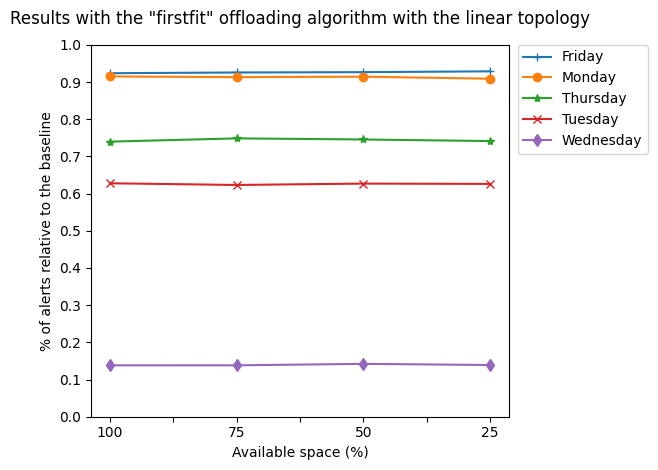

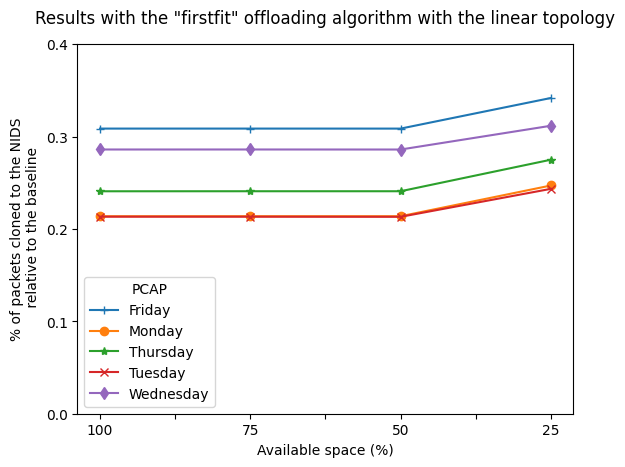

In [44]:
alerts_linear_firstfit_df = linear_firstfit[["PCAP", "Available space (%)", "% of alerts relative to the baseline"]].pivot_table("% of alerts relative to the baseline", ["Available space (%)"], "PCAP")
packets_linear_firstfit_df = linear_firstfit[["PCAP", "Available space (%)", "% of packets cloned to NIDS relative to the baseline"]].pivot_table("% of packets cloned to NIDS relative to the baseline", ["Available space (%)"], "PCAP")

alerts_linear_firstfit_df.index = alerts_linear_firstfit_df.index.map(str)
packets_linear_firstfit_df.index = packets_linear_firstfit_df.index.map(str)

alerts_linear_firstfit_df = alerts_linear_firstfit_df[::-1]
packets_linear_firstfit_df = packets_linear_firstfit_df[::-1]

alerts_linear_firstfit_df.plot(style=['+-', 'o-', '*-', 'x-', 'd-'])
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left', borderaxespad=0)
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.ylim(0,1)
plt.ylabel(alerts_plot_ylabel)
plt.title('Results with the "firstfit" offloading algorithm with the linear topology', pad=15)
plt.tight_layout()
plt.savefig('graphs/Alerts_linear_firstfit.png')
plt.show()

packets_linear_firstfit_df.plot(style=['+-', 'o-', '*-', 'x-', 'd-'])
plt.yticks(np.arange(0, 0.5, step=0.1))
plt.ylim(0,0.4)
plt.ylabel(packets_cloned_plot_ylabel)
plt.title('Results with the "firstfit" offloading algorithm with the linear topology', pad=15)
plt.savefig('graphs/Packets_cloned_linear_firstfit.png')
plt.show()

### Plot dataframe results for the "bestfit" algorithm and linear topology

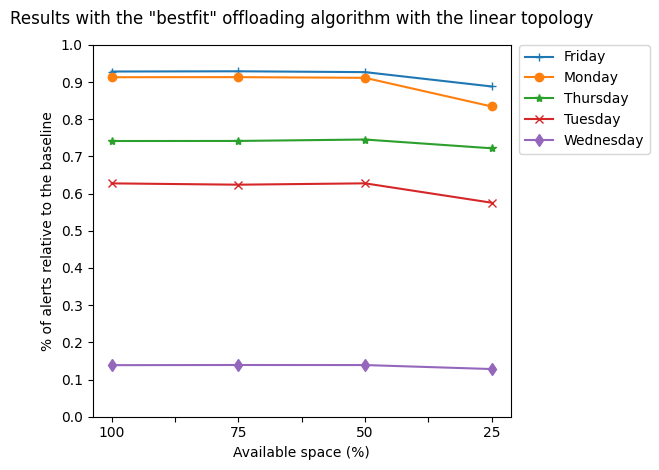

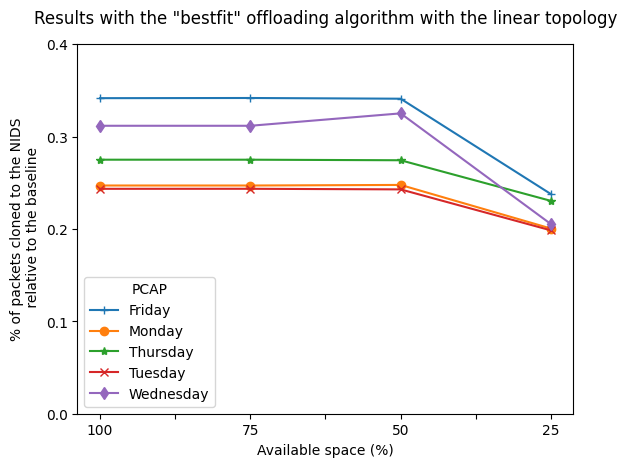

In [43]:
alerts_linear_bestfit_df = linear_bestfit[["PCAP", "Available space (%)", "% of alerts relative to the baseline"]].pivot_table("% of alerts relative to the baseline", ["Available space (%)"], "PCAP")
packets_linear_bestfit_df = linear_bestfit[["PCAP", "Available space (%)", "% of packets cloned to NIDS relative to the baseline"]].pivot_table("% of packets cloned to NIDS relative to the baseline", ["Available space (%)"], "PCAP")

alerts_linear_bestfit_df.index = alerts_linear_bestfit_df.index.map(str)
packets_linear_bestfit_df.index = packets_linear_bestfit_df.index.map(str)

alerts_linear_bestfit_df = alerts_linear_bestfit_df[::-1]
packets_linear_bestfit_df = packets_linear_bestfit_df[::-1]

alerts_linear_bestfit_df.plot(style=['+-', 'o-', '*-', 'x-', 'd-'])
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left', borderaxespad=0)

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.ylim(0,1)
plt.ylabel(alerts_plot_ylabel)
plt.title('Results with the "bestfit" offloading algorithm with the linear topology', pad=15)
plt.tight_layout()
plt.savefig('graphs/Alerts_linear_bestfit.png')
plt.show()

packets_linear_bestfit_df.plot(style=['+-', 'o-', '*-', 'x-', 'd-'])
plt.yticks(np.arange(0, 0.5, step=0.1))
plt.ylim(0,0.4)
plt.ylabel(packets_cloned_plot_ylabel)
plt.title('Results with the "bestfit" offloading algorithm with the linear topology', pad=15)
plt.savefig('graphs/Packets_cloned_linear_bestfit.png')
plt.show()

### Plot dataframe results for the "firstfit" algorithm and tree topology

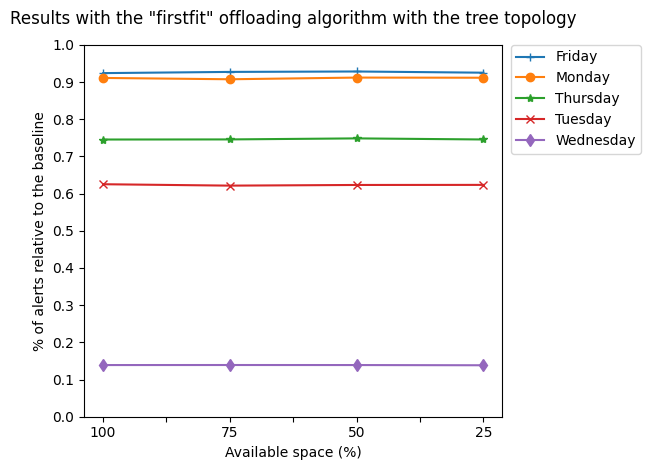

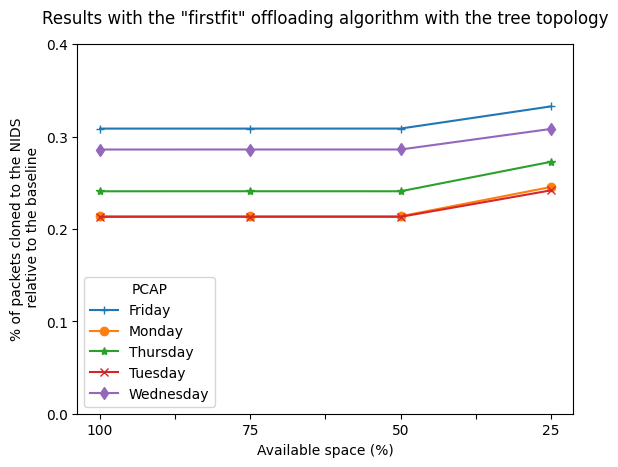

In [42]:
alerts_tree_firstfit_df = tree_firstfit[["PCAP", "Available space (%)", "% of alerts relative to the baseline"]].pivot_table("% of alerts relative to the baseline", ["Available space (%)"], "PCAP")
packets_tree_firstfit_df = tree_firstfit[["PCAP", "Available space (%)", "% of packets cloned to NIDS relative to the baseline"]].pivot_table("% of packets cloned to NIDS relative to the baseline", ["Available space (%)"], "PCAP")

alerts_tree_firstfit_df.index = alerts_tree_firstfit_df.index.map(str)
packets_tree_firstfit_df.index = packets_tree_firstfit_df.index.map(str)

alerts_tree_firstfit_df = alerts_tree_firstfit_df[::-1]
packets_tree_firstfit_df = packets_tree_firstfit_df[::-1]

alerts_tree_firstfit_df.plot(style=['+-', 'o-', '*-', 'x-', 'd-'])
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left', borderaxespad=0)

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.ylim(0,1)
plt.ylabel(alerts_plot_ylabel)
plt.title('Results with the "firstfit" offloading algorithm with the tree topology', pad=15)
plt.tight_layout()
plt.savefig('graphs/Alerts_tree_firstfit.png')
plt.show()

packets_tree_firstfit_df.plot(style=['+-', 'o-', '*-', 'x-', 'd-'])
plt.yticks(np.arange(0, 0.5, step=0.1))
plt.ylim(0,0.4)
plt.ylabel(packets_cloned_plot_ylabel)
plt.title('Results with the "firstfit" offloading algorithm with the tree topology', pad=15)
plt.savefig('graphs/Packets_cloned_tree_firstfit.png')
plt.show()

### Plot dataframe results for the "bestfit" algorithm and tree topology

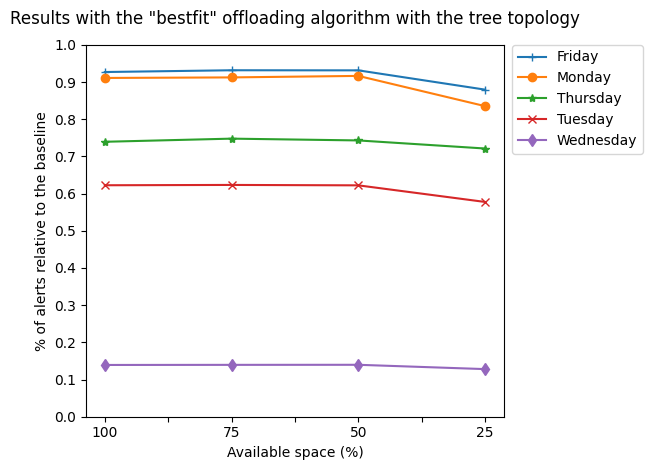

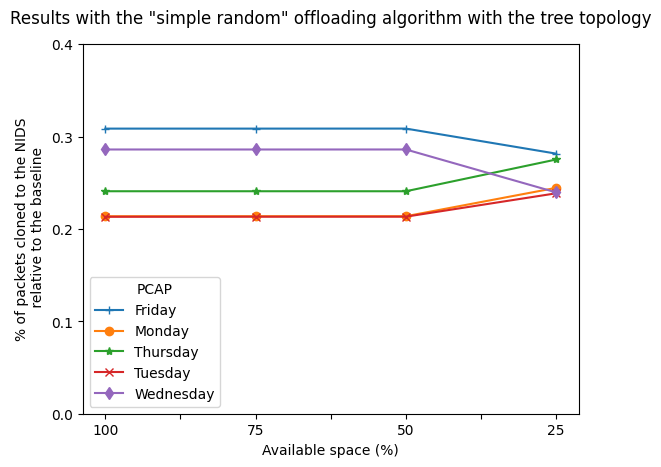

In [41]:
alerts_tree_bestfit_df = tree_bestfit[["PCAP", "Available space (%)", "% of alerts relative to the baseline"]].pivot_table("% of alerts relative to the baseline", ["Available space (%)"], "PCAP")
packets_tree_bestfit_df = tree_bestfit[["PCAP", "Available space (%)", "% of packets cloned to NIDS relative to the baseline"]].pivot_table("% of packets cloned to NIDS relative to the baseline", ["Available space (%)"], "PCAP")

alerts_tree_bestfit_df.index = alerts_tree_bestfit_df.index.map(str)
packets_tree_bestfit_df.index = packets_tree_bestfit_df.index.map(str)

alerts_tree_bestfit_df = alerts_tree_bestfit_df[::-1]
packets_tree_bestfit_df = packets_tree_bestfit_df[::-1]

alerts_tree_bestfit_df.plot(style=['+-', 'o-', '*-', 'x-', 'd-'])
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left', borderaxespad=0)
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.ylim(0,1)
plt.ylabel(alerts_plot_ylabel)
plt.title('Results with the "bestfit" offloading algorithm with the tree topology', pad=15)
plt.tight_layout()
plt.savefig('graphs/Alerts_tree_bestfit.png')
plt.show()

packets_tree_bestfit_df.plot(style=['+-', 'o-', '*-', 'x-', 'd-'])
plt.yticks(np.arange(0, 0.5, step=0.1))
plt.ylim(0,0.4)
plt.ylabel(packets_cloned_plot_ylabel)
plt.title('Results with the "simple random" offloading algorithm with the tree topology', pad=15)
plt.savefig('graphs/Packets_cloned_tree_bestfit.png')
plt.show()